# Virtual machine set up

In [1]:
import sys
if True:  # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/omega/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/omega/")
else:  # Local
    root = './'

Mounted at /content/drive


In [2]:
!pip3 install flax
!pip3 install git+https://github.com/afqueiruga/simdatadb.git
!pip3 install pymysql

     |████████████████████████████████| 143kB 3.3MB/s 
  Cloning https://github.com/afqueiruga/simdatadb.git to /tmp/pip-req-build-96ywe98g
  Running command git clone -q https://github.com/afqueiruga/simdatadb.git /tmp/pip-req-build-96ywe98g
  Created wheel for SimDataDB: filename=SimDataDB-0.1-cp36-none-any.whl size=7801 sha256=2adffcd5d38e57177d87ec3848025f908434eb3919a665cea3262b507c97715b
  Stored in directory: /tmp/pip-ephem-wheel-cache-0k87tfi4/wheels/a4/69/30/849400d8794317dd68c9f1a6cc772929216df887a491763000
Successfully built SimDataDB
     |████████████████████████████████| 51kB 1.9MB/s 


# Imports

In [3]:
from typing import Any, Callable, Iterable, NamedTuple, Tuple

from SimDataDB import SimDataDB
import tqdm

import pendulum_data_setup
from jax_impl import *

# The science

In [4]:
T_MAX_TO_TRAIN = 200.0
THETA_0 = 1.5*onp.pi/2 #pendulum_data_setup.THETA_0

In [5]:
def make_model(f, scheme, dt):
    def my_model(params, x):
        return scheme(params, x, f, dt)
    return jax.vmap(my_model, in_axes=(None, 0))

Why do I love JAX? It does code generation with constant folding! JAX is the language I've been longing for my entire life. We can compile all of these complex forms into reduced instructions:

In [6]:
F = make_model(ShallowOde.call, RK4, 0.1)
_, initial_params = ShallowOde.init_by_shape(
        jax.random.PRNGKey(0), [((2,), jnp.float32)])
jax.make_jaxpr(F)(initial_params,  jnp.array([[1.0, 0.0]]))

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


{ lambda  ; a b c d.
  let e = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
                       precision=None ] d b
      f = broadcast_in_dim[ broadcast_dimensions=(1,)
                            shape=(1, 50) ] a
      g = add e f
      h = tanh g
      i = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
                       precision=None ] h c
      j = mul i 0.1666666716337204
      k = mul i 0.05000000074505806
      l = add d k
      m = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
                       precision=None ] l b
      n = broadcast_in_dim[ broadcast_dimensions=(1,)
                            shape=(1, 50) ] a
      o = add m n
      p = tanh o
      q = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
                       precision=None ] p c
      r = mul q 0.3333333432674408
      s = add j r
      t = mul q 0.05000000074505806
      u = add d t
      v = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
       

In [7]:
class Experiment(NamedTuple):
    """Storage struct for results.
    
    Note: compiled jax functions don't pickle, but this is enough info to
    call the model."""
    scheme: str
    dt: float
    params: Any
    losses: Iterable[float]

In [83]:
#%rm "{root}/jax_results.sqlite"

In [8]:
sdb = SimDataDB(root+'/jax_results.sqlite')
@sdb.Decorate("pendulum64",
              [("scheme","STRING"), ("dt","FLOAT")],
              [("Experiment","pickle")])
def train_a_model(scheme: str, dt: float) -> Tuple[Experiment]:
    data_ts, data = pendulum_data_setup.make_dataset_for(dt_data=dt,
                                                         t_max=T_MAX_TO_TRAIN)

    _, initial_params = ShallowOde.init_by_shape(
        jax.random.PRNGKey(0), [((2,), jnp.float64)])

    F = make_model(ShallowOde.call, SCHEME_TABLE[scheme], dt)

    def loss(params, x, y):
        return jnp.mean(jnp.square(y-F(params, x)))

    @jax.jit
    def update(params, x, y):
        step_size = 0.01
        value, grads = jax.value_and_grad(loss)(params, x, y)
        new_params = jax.tree_multimap(
            lambda v, g : v - step_size * g,
            params, grads)
        return value, new_params
        
    params = initial_params
    # A fixed number of iterations because we have infinite data
    n_steps = 100000 #1*(data.shape[0]-1)
    vs = onp.empty(n_steps)
    for i in tqdm.tqdm(range(n_steps), desc = f"{scheme}@{dt}"):
        idcs = onp.random.choice(data.shape[0]-1, 32)
        x0, y0 = data[idcs,:], data[idcs+1,:]
        v, params = update(params, x0, y0)
        vs[i] = v
    return Experiment(scheme, dt, params, vs),

CREATE TABLE IF NOT EXISTS pendulum64 ( scheme STRING, dt FLOAT, Experiment pickle, timestamp VARCHAR(30), runtime FLOAT );


In [9]:
#%ls "{root}"

In [10]:
experiments = []
DTS_TO_TRAIN = [0.05]  # [ 1.0, 0.2, 0.1, 0.05, 0.01 ]
for scheme in SCHEME_TABLE:
    for dt in DTS_TO_TRAIN:
        experiments.append(train_a_model(scheme, dt))

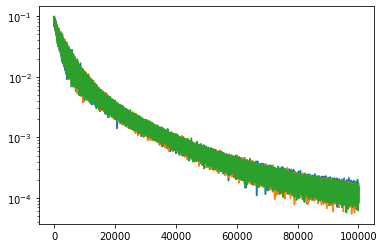

In [11]:
for experiment, in experiments:
    plt.semilogy(experiment.losses)
#plt.ylim(0,0.01)

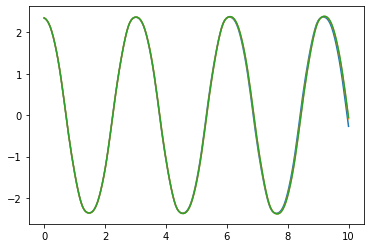

In [88]:
for experiment, in experiments:
    N_step = int(10.0/experiment.dt)
    yy = OdeIntWithPoints(
            experiment.params,
            onp.array([THETA_0,0]),
            ShallowOde.call,
            scheme=SCHEME_TABLE[experiment.scheme],
            Dt=experiment.dt,
            N_step=N_step)
    plt.plot(onp.linspace(0,10.0, N_step), yy[:,0], label=f"{experiment.scheme} @ {experiment.dt}")
#plt.legend()

In [12]:
y_true = pendulum_data_setup.solution_pendulum_theta(onp.array([10.0]), THETA_0)

In [13]:
y_true

array([[-0.22063476, -5.74611358]])

In [14]:
DTS_TO_INFER = [ 1.0, 0.5, 0.2, 0.15, 0.1, 0.075, 0.06, 0.055, 0.052, 0.051, 0.05, 0.049, 0.048, 0.045, 0.04, 0.03, 0.025, 0.01 ]
all_errors = {}
for experiment, in experiments:
    errors = []
    for dt_infer in tqdm.tqdm(DTS_TO_INFER, desc=f"{experiment.scheme} @ {experiment.dt}"):
        N_step = int(10.0/dt_infer)
        y_infer = OdeIntFast(
            experiment.params,
            onp.array([THETA_0,0]),
            ShallowOde.call,
            scheme=SCHEME_TABLE[experiment.scheme],
            Dt=dt_infer,
            N_step=N_step)
        errors.append((dt_infer, onp.linalg.norm(y_infer-y_true)))
    all_errors[(experiment.scheme, experiment.dt)] = errors

RK4 @ 0.05: 100%|██████████| 18/18 [00:28<00:00,  1.59s/it]


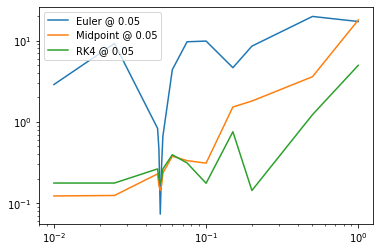

In [96]:
for (scheme, dt), errors in all_errors.items():
    x, y = zip(*errors)
    plt.loglog(x, y, label=f"{scheme} @ {dt}")
plt.legend()